<script type="text/x-mathjax-config">
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});
</script>

<h1><center>Machine Learning in Healthcare Informatics</center></h1>

## Temporal Needleman-Wunsch

Consider two temporal sequences:

>$X = t_{x_1}.x_1, t_{x_2}.x_2,..., t_{x_m}x_m$  
<br><br>
$Y = t_{y_1}.y_1, t_{y_2}.y_2,...,t_{y_n}.y_n$, 
<br><br>
where $t_{x_i}$ and $t_{y_j}$ are the transition times for elements $x_i$ and $y_j$, respectively, for $i\in [1,m]$ and $j\in [1,n]$.

The Temporal Needleman-Wunsch algorithm is a modified version of the Needleman-Wunsch method that incorporates the transition times between elements of a sequence. It gives us the best alignment between two sequences given some user defined parameters.

#### User defined parameters:
* $g$: gap penalty
* $ S(x_i,y_j)$ : pre-defined scoring schema
* f : temporal penalty function
> \begin{equation}
    f(t_{x},t_{y}) = T_p\frac{|t_{x}-t_{y}|}{\max(t_{x},t_{y})}
  \label{eq:temporal_penalty}
  \end{equation}
<br><br>
where $T_p$ is a constant

Similarly to the Needleman-Wunsch consists on three steps:
1. Initialisation of the score matrix $H$, traceback matrix $T$ and auxiliary matrices $TR$ and $TC$
>\begin{equation}
H_{r0} = -rg; \ \ \ H_{0c} = -cg \quad \forall r \in [0,m], c \in [0,n]
\label{eq:init}
\end{equation}

2. Calculation of scores, filling the traceback matrix and auxiliary matrices
>\begin{equation}
	H_{i,j} = \max 
	\left\{\!\begin{aligned}
&H_{i-1,j-1} + S(x_i,y_j) - f(t_{x_i}+TR_{i-1,j-1},t_{y_j}+TC_{i-1,j-1}) (*)\\[1ex]
&H_{i-1,j} - g \\[1ex]
&H_{i,j-1} - g
\end{aligned}\right\}, \quad \forall i \in [1,m], j \in [1,n]
\label{eq:tnw}
\end{equation}
<br><br>
\begin{equation}
TR_{i,j}=
  \begin{cases}
    0, & \text{if $T_{i,j} =$ 'diag'}\\
    TR_{i,j-1} & \text{if $T_{i,j}=$ 'left'}\\
    TR_{i-1,j} + t_{xi} & \text{if $T_{i,j}=$ 'up'}
  \end{cases}
  \label{eq:TR}
\end{equation}
<br><br>
\begin{equation}
TC_{i,j}=
  \begin{cases}
    0, & \text{if $T_{i,j} =$ 'diag'}\\
    TC_{i,j-1} + t_{yj} & \text{if $T_{i,j}=$ 'left'}\\
    Tc_{i-1,j}  & \text{if $T_{i,j}=$ 'up'}
  \end{cases}
  \label{eq:TC}
\end{equation}
<br><br>
\begin{equation}
T_{i_,j}=
   \begin{cases}
     \text{'diag'}, & \text{if $H_{i,j} =$ *}\\
     \text{'up'} & \text{if $H_{i,j}= $ $H_{i-1,j} - g$}\\
    \text{'left'}  & \text{if $H_{i,j}=$ $H_{i,j-1} - g$}
  \end{cases}
  \label{eq:T}
\end{equation}

3. Deducing the alignment from the traceback matrix


### Example

>$ X = 0.A,t_1.B,t_2.C,t_3.D $
<br><br>
$ Y = 0.A,t_4.D $
<br><br>
where $t_4 = t_1+t_2+t_3$
<br><br>
Lets assume $t_1=1,t_2=2,t_3=1$ and  $t_4=4$

For this example the user-defined parameters are:

* $g = 0.5$
* simple scoring system: exact matching events get a score of 1 and events that do not match get a score of -1.1
* $T_p = 0.25$


#### 1. Initialisation

We start building our matrix $H$ using equation \ref{eq:init}. The remaining matrices are computed using equations \ref{eq:TR}, \ref{eq:TC} and \ref{eq:T} with the exception of the first entry which is $TR_{00} = 0$, $TC_{00} = 0$ and $T_{00} =$ 'done'. The following animation show us the initialisiaton of all entries of our 4 matrices. In black we have the values of the score matrix ($H_{ij}$) and traceback matrix ($T_{ij}$), in <font color='blue'>blue</font> and in <font color='green'>green</font>  it is represented the entries of matrix $TR$ and $TC$ respectively.


<img id="img1" src="tnw_initialisation_gif.gif">

<a onClick="resetGif('img1')">reset gif initialisation</a>

<script type="text/javascript">

// reset an animated gif to start at first image without reloading it from server.
// Note: if you have the same image on the page more than ones, they all reset.
function resetGif(id) {
    var img = document.getElementById(id);
    var imageUrl = img.src;
    img.src = "#";
    img.src = imageUrl;
};

</script>

#### 2. Calculations

Now for the calculation of the entries of matrix $H$ we use equation \ref{eq:tnw}. The other matrices entries are computed as above. The following animation show us the computation of all remaining entries.

<img id="img2" src="tnw_calculations_gif.gif">

<a onClick="resetGif('img2')">reset gif calculations</a>


#### 3. Alignment

Finnaly the alignment is obtained by analysing the matrix $T$. The following animation show us how to obtain the alignment. Whenever we see 'diag' it means that a 'pair' of elements is matched; 'up' means that an element of sequence $X$ is aligned with gap whereas 'left' an element of sequence $Y$ is aligned with a gap.

<img id="img3" src="tnw_alignment_gif.gif">

<a onClick="resetGif('img3')">reset gif alignment</a>


### Implementation

In [1]:
import numpy as np
import itertools
from IPython.display import display, HTML

In [2]:
#initialize pre-defined scoring dictionary
def scoring_schema():
    
    match = 1
    mismatch = -1.1
    
    s = {'OO': match}
    #get all combinations of letters
    comb = list(itertools.product('ABCDEFGHIJZ',repeat = 2))

    #construct the pre-defined scoring system
    for pairs in comb:
        if(pairs[0]==pairs[1]):
            s[pairs[0]+pairs[1]] = match
        else:
            s[pairs[0]+pairs[1]] = mismatch
    
    return s
         

# Initialisation of the score matrix
def score_initialisation(rows,cols,gap):
    
            
    score=np.zeros((rows,cols),float)

    for i in range(rows):
        score[i][0] = -i*gap
    for j in range(cols):
        score[0][j] = -j*gap
             
    return score

# Initialisation of the traceback matrix
def traceback_initialisation(rows,cols):
    
            
    traceback=np.zeros((rows,cols))

    # end of path top left corner
    traceback[0][0] = -1

    #going up
    for i in range(1,rows):
        traceback[i][0] = 1 
    
    #going left
    for j in range(1,cols):
        traceback[0][j] = 2
             
    return traceback


# Initialisation of the TR matrix
def TR_initialisation(rows,cols,traceback,seq2):
    
            
    TR=np.zeros((rows,cols))

    # end of path top left corner
    TR[0][0] = 0

    #going up
    for i in range(1,rows):
        TR[i][0] = TR[i-1][0]+float(seq2[i-1][0]) 
    
    #going left
    for j in range(1,cols):
        TR[0][j] = 0
             
    return TR

# Initialisation of the TC matrix
def TC_initialisation(rows,cols,traceback,seq1):
    
            
    TC=np.zeros((rows,cols))

    # end of path top left corner
    TC[0][0] = 0

    #going up
    for i in range(1,rows):
        TC[i][0] = 0
    
    #going left
    for j in range(1,cols):
        TC[0][j] = TC[0][j-1]+float(seq1[j-1][0]) 
             
    return TC

# calculation of the scores and filling the traceback matrix
def calculate_scores(score,traceback,rows,cols,seq1,seq2,TR,TC,s,gap,T):    
    
    for i in range(1,rows):
        for j in range(1,cols):
            # Dynamic programing -- aka. divide and conquer:
            # Since gap penalties are linear in gap size
            # the score of an alignmet of length l only depends on the   
            # the l-th characters in the alignment (match - mismatch - gap)
            # and the score of the one shorter (l-1) alignment,
            # i.e. we can calculate how to extend an arbritary alignment
            # soley based on the previous score value.  
            
            if i-1 == 0 and j-1 == 0:
                tp = 0
            else:
                num = abs(float(seq2[i-1][0])+TR[i-1][j-1]-float(seq1[j-1][0])-TC[i-1][j-1])
                den = max(float(seq2[i-1][0])+TR[i-1][j-1],float(seq1[j-1][0])+TC[i-1][j-1])
                #temporal penalty function
                tp = T*(num/den)
                
            choice1 = score[i-1][j-1] + s[(seq1[j-1][1] + seq2[i-1][1])] - tp #diagonal
            choice2 = score[i-1][j] - gap #up
            choice3 = score[i][j-1] - gap #left
            choices = [choice1,choice2,choice3]
            score[i][j] = max(choices)    
            
            # update traceback matrix 0-diagonal, 1-up, 2-left
            traceback[i][j] = choices.index(max(choices))
            
            #update TR and TC matrices
            if traceback[i][j] == 0:
                TR[i][j] = 0
                TC[i][j] = 0
                  
            elif traceback[i][j] == 1:
                TR[i][j] = TR[i-1][j] + float(seq2[i-1][0])
                TC[i][j] = TC[i-1][j]
                
            elif traceback[i][j] == 2:
                TR[i][j] = TR[i][j-1] 
                TC[i][j] = TC[i][j-1] + float(seq1[j-1][0])
                
# deducing the alignment from the traceback matrix
def alignment(traceback,rows,cols,seq1,seq2):

    aseq1 = ''
    aseq2 = ''
    
    #number of aligned events
    count_aligned = 0
    
    #We reconstruct the alignment into aseq1 and aseq2, 
    j = cols-1
    i = rows-1
    while i>0 and j>0:
        
        # going diagonal
        if traceback[i][j] == 0:
            aseq1 = seq1[j-1][1] + aseq1
            aseq2 = seq2[i-1][1] + aseq2
            i -= 1
            j -= 1
            count_aligned = count_aligned + 1
        # going up -gap in sequence1 (top one)
        elif traceback[i][j] == 1:
            aseq1 = '_' + aseq1
            aseq2 = seq2[i-1][1] + aseq2
            i -= 1
        # going left -gap in sequence2 (left one)
        elif traceback[i][j] == 2:
            aseq1 = seq1[j-1][1] + aseq1
            aseq2 = '_' + aseq2
            j -= 1
        else:
            #should never get here..
            print('ERROR')
            i=0
            j=0
            aseq1='ERROR';aseq2='ERROR';seq1='ERROR';seq2='ERROR'
    
    while i>0:
        #If we hit j==0 before i==0 we keep going in i (up).
        aseq1 = '_' + aseq1
        aseq2 = seq2[i-1][1] + aseq2
        i -= 1     

    while j>0:
        #If we hit i==0 before j==0 we keep going in j (left).
        aseq1 = seq1[j-1][1] + aseq1
        aseq2 = '_' + aseq2
        j -= 1
        
        
    aligned = [aseq1, aseq2, count_aligned]
    
    return aligned
    
# main algorithm
def tnw(seq1_encoded,seq2_encoded,gap,T,ss):

    
    aux1 = seq1_encoded.split(",")
    aux2 = seq2_encoded.split(",")
    
    seq1 = []
    seq2 = []
    
    for seq in aux1:
        seq1.append(seq.split("."))

    for seq in aux2:
        seq2.append(seq.split("."))
        
    cols=len(seq1)+1
    rows=len(seq2)+1
            
    #initialisation of matrices
    score = score_initialisation(rows,cols,gap)
    traceback = traceback_initialisation(rows,cols)
    TR = TR_initialisation(rows,cols,traceback,seq2)
    TC = TC_initialisation(rows,cols,traceback,seq1)
    
    #computing matrices
    calculate_scores(score,traceback,rows,cols,seq1,seq2,TR,TC,ss,gap,T)
    
    #deducing alignment
    sequences_aligned = alignment(traceback,rows,cols,seq1,seq2)
    
    print("score")
    print(score)
    print("traceback")
    print(traceback)
    print("TR")
    print(TR)
    print("TC")
    print(TC)
    
    print(sequences_aligned[0])
    print(sequences_aligned[1])
    
    return score[rows-1,cols-1]

In [3]:
seq1_encoded = '0.A,4.D'
seq2_encoded = '0.A,1.B,2.C,1.D'

gap = 0.5
T = 0.25
#scoring schema
ss = scoring_schema()

tnw(seq1_encoded,seq2_encoded,gap,T,ss)

score
[[ 0.  -0.5 -1. ]
 [-0.5  1.   0.5]
 [-1.   0.5  0. ]
 [-1.5  0.  -0.5]
 [-2.  -0.5  1. ]]
traceback
[[-1.  2.  2.]
 [ 1.  0.  2.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  0.]]
TR
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  1.  1.]
 [ 3.  3.  3.]
 [ 4.  4.  0.]]
TC
[[ 0.  0.  4.]
 [ 0.  0.  4.]
 [ 0.  0.  4.]
 [ 0.  0.  4.]
 [ 0.  0.  0.]]
A__D
ABCD


1.0

#### Effect of varying the gap penalty $g$

The example below can be considered a good alignment. The letter 'A' from the two sequences match and the remaining ones do not match hence gaps were introduced.

In [4]:
seq1_encoded = '0.A,1.B,1.C'
seq2_encoded = '0.A,1.D,2.E'

gap = 0.5
T = 0.25

tnw(seq1_encoded,seq2_encoded,gap,T,ss)

score
[[ 0.  -0.5 -1.  -1.5]
 [-0.5  1.   0.5  0. ]
 [-1.   0.5  0.  -0.5]
 [-1.5  0.  -0.5 -1. ]]
traceback
[[-1.  2.  2.  2.]
 [ 1.  0.  2.  2.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]
TR
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 1.  1.  1.  1.]
 [ 3.  3.  3.  3.]]
TC
[[ 0.  0.  1.  2.]
 [ 0.  0.  1.  2.]
 [ 0.  0.  1.  2.]
 [ 0.  0.  1.  2.]]
ABC__
A__DE


-1.0

When we increase the gap penalty, 'letters' that do not match start to align.

In [5]:
gap = 1
T = 0.25

tnw(seq1_encoded,seq2_encoded,gap,T,ss)

score
[[ 0.    -1.    -2.    -3.   ]
 [-1.     1.     0.    -1.   ]
 [-2.     0.    -0.1   -1.1  ]
 [-3.    -1.    -1.1   -1.325]]
traceback
[[-1.  2.  2.  2.]
 [ 1.  0.  2.  2.]
 [ 1.  1.  0.  2.]
 [ 1.  1.  1.  0.]]
TR
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 1.  1.  0.  0.]
 [ 3.  3.  2.  0.]]
TC
[[ 0.  0.  1.  2.]
 [ 0.  0.  1.  2.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  0.]]
ABC
ADE


-1.3250000000000002

If we decrease the gap penalty and start to choose negative gap penaltys then we obtain total misalignment.

In [6]:
gap = -0.5
T = 0.25

tnw(seq1_encoded,seq2_encoded,gap,T,ss)

score
[[-0.   0.5  1.   1.5]
 [ 0.5  1.   1.5  2. ]
 [ 1.   1.5  2.   2.5]
 [ 1.5  2.   2.5  3. ]]
traceback
[[-1.  2.  2.  2.]
 [ 1.  0.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]
TR
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 1.  1.  1.  1.]
 [ 3.  3.  3.  3.]]
TC
[[ 0.  0.  1.  2.]
 [ 0.  0.  1.  2.]
 [ 0.  0.  1.  2.]
 [ 0.  0.  1.  2.]]
ABC___
___ADE


3.0

#### Effect of varying the temporal penalty constant $T_p$

The temporal penalty constant $T_p$ imposes a maximum penalty on $S(x_i,y_j)$. (equations \ref{eq:temporal_penalty} and \ref{eq:tnw}). When using small values for $T_p$ the alignments that we obtain are generally the same the we would obtain if we did not use temporal distances, although the scores computed in each case will be different. 

In [7]:
seq1_encoded = '0.A,100.B,100.C'
seq2_encoded = '0.A,120.B,20.C'

gap = 0.5
T = 0.25

tnw(seq1_encoded,seq2_encoded,gap,T,ss)

score
[[ 0.         -0.5        -1.         -1.5       ]
 [-0.5         1.          0.5         0.        ]
 [-1.          0.5         1.95833333  1.45833333]
 [-1.5         0.          1.45833333  2.75833333]]
traceback
[[-1.  2.  2.  2.]
 [ 1.  0.  2.  2.]
 [ 1.  1.  0.  2.]
 [ 1.  1.  1.  0.]]
TR
[[   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [ 120.  120.    0.    0.]
 [ 140.  140.   20.    0.]]
TC
[[   0.    0.  100.  200.]
 [   0.    0.  100.  200.]
 [   0.    0.    0.  100.]
 [   0.    0.    0.    0.]]
ABC
ABC


2.7583333333333329

By increasing $T_p$ we want to show how much the score changes despite the alignment being the same.

In [8]:
gap = 0.5
T = 1.5

tnw(seq1_encoded,seq2_encoded,gap,T,ss)

score
[[ 0.   -0.5  -1.   -1.5 ]
 [-0.5   1.    0.5   0.  ]
 [-1.    0.5   1.75  1.25]
 [-1.5   0.    1.25  1.55]]
traceback
[[-1.  2.  2.  2.]
 [ 1.  0.  2.  2.]
 [ 1.  1.  0.  2.]
 [ 1.  1.  1.  0.]]
TR
[[   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [ 120.  120.    0.    0.]
 [ 140.  140.   20.    0.]]
TC
[[   0.    0.  100.  200.]
 [   0.    0.  100.  200.]
 [   0.    0.    0.  100.]
 [   0.    0.    0.    0.]]
ABC
ABC


1.5499999999999998

Increasing $T_p$ too much can lead to misalignments as well.

In [9]:
gap = 0.5
T = 10

tnw(seq1_encoded,seq2_encoded,gap,T,ss)

score
[[ 0.         -0.5        -1.         -1.5       ]
 [-0.5         1.          0.5         0.        ]
 [-1.          0.5         0.33333333 -0.16666667]
 [-1.5         0.         -0.16666667 -0.66666667]]
traceback
[[-1.  2.  2.  2.]
 [ 1.  0.  2.  2.]
 [ 1.  1.  0.  2.]
 [ 1.  1.  1.  1.]]
TR
[[   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [ 120.  120.    0.    0.]
 [ 140.  140.   20.   20.]]
TC
[[   0.    0.  100.  200.]
 [   0.    0.  100.  200.]
 [   0.    0.    0.  100.]
 [   0.    0.    0.  100.]]
ABC_
AB_C


-0.66666666666666652

What we can conclude by tuning some of the parameters of the TNW algorithm that the alignments that we obtained are completely dependent on the parameters that we choose. The user has to choose the parameters depending on what type of alignments he wants and how much emphasys does he want to put on temporal distances.

##  Agglomerative Hierarchical Clustering

Agglomerative Hierarchical Clustering starts with every object (in this work patients) as a single cluster. Then, in each succesive iteration, it merges the two closest clusters until all objects fall into one cluster.

The results of hierarchical clustering are usually presented in a dendrogram, allowing to visualize a tree showing the order and distances of merges during the hierarchical clustering. The main steps of this approach are:

> 1. Start with a collection $C$ of $n$ single clusters, each cluster $c_i$ contains one object $x_i$.
2. Repeat until one cluster is left:
    <br><br>
    1. find a pair of clusters that are closest to each other: $ \displaystyle\min_{i,j} D(c_i,c_j)$.
    2. merge the cluster $c_i$ with $c_j$ to form a new cluster $c_{i+j}$
    3. remove $c_i$ and $c_j$ from the collection C and add $c_{i,j}$ to C
    
This approach requires a distance metric over clusters that measure the cluster distance $D(c_i,c_j)$. In this work 5 different metrics were tested.

<!---


\begin{minipage}{.5\textwidth}
  \centering
  \textbf{Centroids:}
\begin{equation*}
D(c_1,c_2) = D\left(\left(\frac{1}{|c_1|} \sum_{x \in c_1} x\right),\left(\frac{1}{|c_2|} \sum_{x \in c_2} x\right)\right)
\end{equation*}
\end{minipage}%
\begin{minipage}{.5\textwidth}
  \centering
  \includegraphics[width=0.5\columnwidth]{centroids.png}
\end{minipage}
-->
  
<table style="width:100%" cellspacing="0" cellpadding="0">
  <tr>
    <th> Single </th>
    <th>\begin{equation*}
D(c_1,c_2) = \displaystyle\min_{x_1 \in c_1, x_2 \in c_2} D(x_1,x_2)
\end{equation*}</th> 
    <th><img src="single.png" alt="Drawing" style="width: 250px;"/></th>
  </tr>
  
    <tr>
    <th> Complete </th>
    <th>\begin{equation*}
D(c_1,c_2) = \displaystyle\max_{x_1 \in c_1, x_2 \in c_2} D(x_1,x_2)
\end{equation*}</th> 
    <th><img src="complete.png" alt="Drawing" style="width: 250px;"/></th>
  </tr>
  
    <tr>
    <th> Average </th>
    <th>\begin{equation*}
D(c_1,c_2) = \frac{1}{|c_1|} \frac{1}{|c_2|} \sum_{x_1 \in c_2} \sum_{x_2 \in c_2} D(x_1,x_2)
\end{equation*}</th> 
    <th><img src="average.png" alt="Drawing" style="width: 250px;"/></th>
  </tr>
  
    <tr>
    <th> Centroids </th>
    <th>\begin{equation*}
D(c_1,c_2) = D\left(\left(\frac{1}{|c_1|} \sum_{x \in c_1} x\right),\left(\frac{1}{|c_2|} \sum_{x \in c_2} x\right)\right)
\end{equation*}</th> 
    <th><img src="centroids.png" alt="Drawing" style="width: 250px;"/></th>
  </tr>
  
     <tr>
    <th> Ward </th>
    <th>\begin{equation*}
            D(c_1,c_2) = \sum_{x \in c_1} (x-r_1)^2 + \sum_{x \in c_2} (x-r_2)^2 - \sum_{x \in c_{12}} (x-r_{12})^2 \\
            r_1 : \text{centroid of $c_1$} \\ 
            r_2 : \text{centroid of $c_2$} \\
            r_{12} : \text{centroid of $c_{12}$}
        \end{equation*} 
    </th> 
    <th>
    </th>
  </tr>
  
</table>


## Experiments

The proposed approach consists on first taking the raw data from Reuma database and create temporal sequences. Next we perform sequence alignment between all pairs of patients. After the alignment step we obtain a similarity matrix that has to be transformed into a dissimilarity matrix to be used on Hierarchical Clustering. Once the clustering is performed an analysis has to be made concerning the decision on the number of clusters. Finnally a clinical interpretation has to be made.

<img src="approach.png"/>

### Experiment 1 - Biological therapy sequences



In [10]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, cophenet
from fastcluster import linkage
import pandas as pd
from encoder_sequence import encode

#### Raw data

In [11]:
#read .csv file
df = pd.read_csv('bio_corrente_sequence.csv',sep = ';')
df.head(10)

,id_doente,n_bio_corrente,n_dias_duracao
0,33496,2,156.0
1,33496,2,156.0
2,33496,2,156.0
3,33496,2,156.0
4,33496,3,314.0
5,33496,3,314.0
6,33496,3,314.0
7,33496,3,314.0
8,33496,3,314.0
9,33496,4,1696.0


#### Create the temporal sequences

In [26]:
#get the encoded sequences
df_encoded = encode(df)
df_encoded.head(5)

,id_doente,aux_encode
0,33496,"0.B,156.C,314.D,1696.Z"
1,33499,"0.B,148.Z"
2,33502,"0.A,120.B,2187.Z"
3,33505,"0.A,873.B,255.C,1145.Z"
4,33508,"0.A,358.B,420.C,963.D,239.Z"


#### All-Pair Sequence Alignment

In [27]:
# main algorithm
# normalized = 1 - scores are normalized to the strings that are aligned
# normalized = 0 - scores are not normalized

def main_algorithm(df_encoded,gap,T,ss,normalized):
    
    #get all the possible combinations between the patients to perform alignment
    patient_comb = list(itertools.combinations(df_encoded['id_doente'],2))
    
    #set id_doente as index column it will be helpful for later manipulation of sequences
    df_encoded.set_index('id_doente',inplace=True)
    
    results = pd.DataFrame(patient_comb,columns = ['patient1','patient2'])
    list_sequences_aligned = []
    list_scores = []
    list_sequences = []
    
    #analyze every possible combination between patints
    for patient_pair in patient_comb:
        #get the sequences to be aligned
        seq1_encoded = df_encoded.loc[patient_pair[0],'aux_encode']
        seq2_encoded = df_encoded.loc[patient_pair[1],'aux_encode']
    
        list_sequences.append([seq1_encoded,seq2_encoded])
         #split the sequences
        aux1 = seq1_encoded.split(",")
        aux2 = seq2_encoded.split(",")
        
        seq1 = []
        seq2 = []
        
        for seq in aux1:
            seq1.append(seq.split("."))
    
        for seq in aux2:
            seq2.append(seq.split("."))
            
        cols=len(seq1)+1
        rows=len(seq2)+1
                
        score = score_initialisation(rows,cols,gap)
        traceback = traceback_initialisation(rows,cols)
        TR = TR_initialisation(rows,cols,traceback,seq2)
        TC = TC_initialisation(rows,cols,traceback,seq1)
        
        calculate_scores(score,traceback,rows,cols,seq1,seq2,TR,TC,ss,gap,T)
        sequences_aligned = alignment(traceback,rows,cols,seq1,seq2)
        
        list_sequences_aligned.append(sequences_aligned)
        
        if(normalized == 1):
            #normalization of scores
            list_scores.append((score[rows-1][cols-1])/sequences_aligned[2])
        else:
            list_scores.append(score[rows-1][cols-1])
    
    results['sequences'] = pd.Series(list_sequences)
    results['sequences_aligned'] = pd.Series(list_sequences_aligned)
    results['score'] = pd.Series(list_scores)
    return results

In [28]:
gap = 0.5
T = 0.25

results = main_algorithm(df_encoded,gap,T,ss,0)
results.head(5)

,patient1,patient2,sequences,sequences_aligned,score
0,33496,33499,"[0.B,156.C,314.D,1696.Z, 0.B,148.Z]","[BCDZ, B__Z, 2]",0.767082
1,33496,33502,"[0.B,156.C,314.D,1696.Z, 0.A,120.B,2187.Z]","[_BCDZ, AB__Z, 2]",0.247599
2,33496,33505,"[0.B,156.C,314.D,1696.Z, 0.A,873.B,255.C,1145.Z]","[_BCDZ, ABC_Z, 3]",1.545354
3,33496,33508,"[0.B,156.C,314.D,1696.Z, 0.A,358.B,420.C,963.D...","[_BCDZ, ABCDZ, 4]",2.709603
4,33496,33511,"[0.B,156.C,314.D,1696.Z, 0.A,2192.Z]","[BCD_Z, ___AZ, 1]",-1.002965


#### Hierarchical Clustering

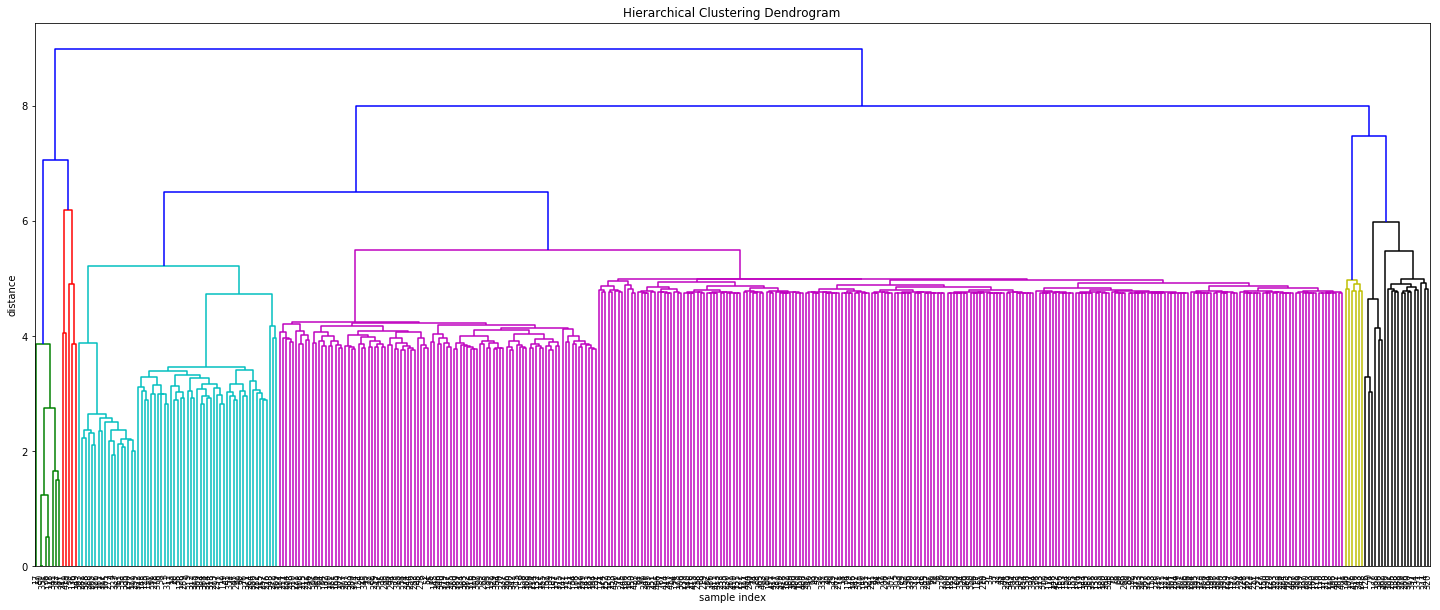

Cophenetic Correlation Coefficient: 0.812794532195


In [29]:
#Convert the score matrix into a distance matrix by making all values positives
results['score'] = 0 - results['score']
results['score'] = results['score'] + abs(results['score'][results['score'].idxmin()])
#results['score'] = 1/(results['score'])
#results.loc[results['score'] == float('inf'), 'score'] = 100

Z = linkage(results['score'], 'complete')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
        Z,
        #truncate_mode = 'lastp',
        #p=6,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        )
plt.show()

c, coph_dists = cophenet(Z, results['score'])

print('Cophenetic Correlation Coefficient:', c)